<a id=top></a>
# 1D Spectra Extraction <a class="tocSkip">

In [17]:
# Import for: Reading in fits file
from astropy.io import fits
from astropy.table import Table

# Import for: Downloading necessary files. (Not necessary if you choose to collect data from MAST)
from astroquery.mast import Observations

# Import for: Managing system variables and paths
import os

# Import for: Quick Calculation and Data Analysis
import numpy as np

# Import for: Operations on STIS Data
# import stistools

# Import for: Plotting and specifying plotting parameters
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
# from matplotlib.ticker import FixedLocator

In [18]:
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.cmap'] = 'viridis'
matplotlib.rcParams['image.interpolation'] = 'none'

### 0.2 Collect Data Set From the MAST Archive Using Astroquery
There are other ways to download data from MAST such as using CyberDuck. The steps of collecting data is beyond the scope of this notebook, and we are only showing how to use astroquery.

In [19]:
# change this field in you have a specific dataset to be explored
#obs_id = 'odj102010'
# Search target object by obs_id
#target = Observations.query_criteria(obs_id=obs_id)
# get a list of files assiciated with that target
#target_list = Observations.get_product_list(target)
# Download fits files
#result = Observations.download_products(target_list, extension=['_flt.fits', '_x1d.fits'], productType=['SCIENCE'])
#flt_filename = os.path.join(f'./mastDownload/HST/{obs_id}/{obs_id}_flt.fits')
#x1d_filename = os.path.join(f'./mastDownload/HST/{obs_id}/{obs_id}_x1d.fits')
flt_filename = os.path.join('/home/serat/Downloads/AGN/data/reduced/of0a02070_lacos_new.fits')
x1d_filename = os.path.join('/home/serat/Downloads/AGN/data/reduced/example_1D_3.fits')

## 1 `x1d` FITS File Structure
The `x1d` file is a multi-extension FITS file with header information stored in the primary extension (note that for CCD data the similar extension is `sx1`), and the science data stored in the first extension called "SCI".

In [20]:
fits.info(x1d_filename)

Filename: /home/serat/Downloads/AGN/data/reduced/example_1D_3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     388   ()      
  1  SCI           1 BinTableHDU    156   1R x 19C   [1I, 1I, 1024D, 1024E, 1024E, 1024E, 1024E, 1024E, 1024E, 1024I, 1E, 1E, 1I, 1E, 1E, 1E, 1E, 1024E, 1E]   


The SCI extension contains the science data of the spectra along the spectral direction such as the wavelength and the flux, and information on the extraction region and the background region when performing the 1D spectra extraction:

| Column name   | Description | Data Type |
| :---------- | :---------- | :---------- |
| EXTRLOCY      | an array that gives the location of the center of the spectral trace for each pixel along the Y direction | float32 array[1024] |
| A2CENTER      | row number in the y direction at which the spectral trace is centered | float32 |
| EXTRSIZE      | height of extraction region | float32 |
| BK1SIZE     | height of background region above the extraction region | float32 |
| BK2SIZE     | height of background region below the extraction region | float32 |
| BK1OFFST    | background region offset from the center of the extraction region above the extraction region | float32 |
| BK2OFFST    | background region offset from the center of the extraction region below the extraction region | float32 |

In [21]:
cols = ['SPORDER', 'WAVELENGTH', 'FLUX', 'EXTRLOCY', 'A2CENTER', 'EXTRSIZE', 'BK1SIZE', 'BK2SIZE', 'BK1OFFST', 'BK2OFFST']
Table.read(x1d_filename)[cols]

SPORDER,WAVELENGTH,FLUX,EXTRLOCY,A2CENTER,EXTRSIZE,BK1SIZE,BK2SIZE,BK1OFFST,BK2OFFST
,Angstroms,erg / (Angstrom s cm2),pix,pix,pix,pix,pix,pix,pix
int16,float64[1024],float32[1024],float32[1024],float32,float32,float32,float32,float32,float32
1,6993.790380446205 .. 7561.713036334872,4.669948e-16 .. 1.824938e-16,898.4592 .. 890.1977,893.975,7,5,5,-300,-320


**Note that X1D columns in pixel units (e.g. `EXTRLOCY`) are in one-indexed coordinates. Thus when visualizing the extraction region with Python (zero-indexed), the pixel coordinates need to be subtracted by 1. Additionally, the n-th pixel (in one-index coordinates) ranges from n-0.5 to n+0.5.**

## 2 Plot the Extraction Region

**Left:**  The 2D `FLT` image.

**Right:**  The 2D `FLT` image with extraction regions over-plotted. The extraction region is plotted in red, and the 2 background regions are plotted in orange.

To zoom in to a specific region along the Y axis, pass in the optional parameter yrange.

In [22]:
def show_extraction_regions(x1d_filename, flt_filename, sci_ext=1, row=0, xrange=None, yrange=None):
    
    fig, axes = plt.subplots(1, 2, sharey=True)
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.88)
    fig.set_figwidth(10)
    fig.set_figheight(5)
    fig.suptitle(os.path.basename(x1d_filename))
    
    x1d = fits.getdata(x1d_filename, ext=sci_ext)[row]
    flt = fits.getdata(flt_filename, ext=('SCI', sci_ext))
    
    # LEFT & Right PLOTS:
    for ax in axes[0:2]:
        # Display the 2D FLT spectrum on the left:
        ax.imshow(flt, origin='lower', interpolation='none', aspect='auto', vmin=-6, vmax=15)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

    # Right PLOT:
    axes[1].set_title(f"A2CENTER={x1d['A2CENTER']:.2f}")
    # Extraction region in red:
    axes[1].plot(np.arange(1024), 
                 x1d['EXTRLOCY'] - 1, 'r:', alpha=0.6)
    axes[1].plot(np.arange(1024), 
                 x1d['EXTRLOCY'] - 1 - x1d['EXTRSIZE']//2,
                 color='red', alpha=0.6)
    axes[1].plot(np.arange(1024), 
                 x1d['EXTRLOCY'] - 1 + x1d['EXTRSIZE']//2,
                 color='red', alpha=0.6)
    # Background regions in orange:
    axes[1].plot(np.arange(1024), 
                 x1d['EXTRLOCY'] - 1 + x1d['BK1OFFST'] - x1d['BK1SIZE']//2,
                 color='orange', alpha=0.6)
    axes[1].plot(np.arange(1024), 
                 x1d['EXTRLOCY'] - 1 + x1d['BK1OFFST'] + x1d['BK1SIZE']//2,
                 color='orange', alpha=0.6)
    axes[1].plot(np.arange(1024), 
                 x1d['EXTRLOCY'] - 1 + x1d['BK2OFFST'] - x1d['BK2SIZE']//2, 
                 color='orange', alpha=0.6)
    axes[1].plot(np.arange(1024), 
                 x1d['EXTRLOCY'] - 1 + x1d['BK2OFFST'] + x1d['BK2SIZE']//2, 
                 color='orange', alpha=0.6)
    
    axes[0].set_xlim(-0.5, 1023.5)
    axes[0].set_ylim(-0.5, 1023.5)
    axes[1].set_xlim(-0.5, 1023.5)
    axes[1].set_ylim(-0.5, 1023.5)
    
    if xrange is not None:
        axes[0].set_xlim(xrange[0], xrange[1])
        axes[1].set_xlim(xrange[0], xrange[1])
    if yrange is not None:
        axes[0].set_ylim(yrange[0], yrange[1])
        axes[1].set_ylim(yrange[0], yrange[1])

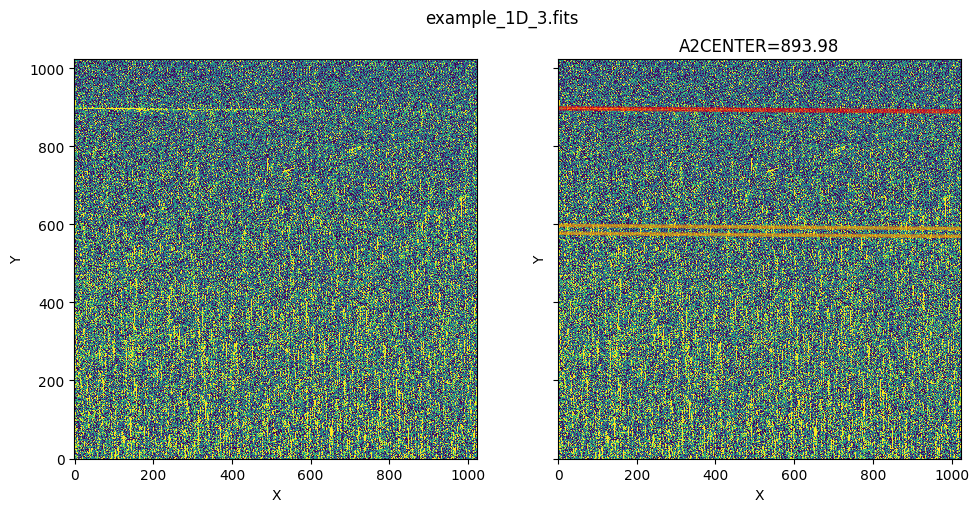

In [23]:
show_extraction_regions(x1d_filename, flt_filename)

Zoom in to the extraction region:

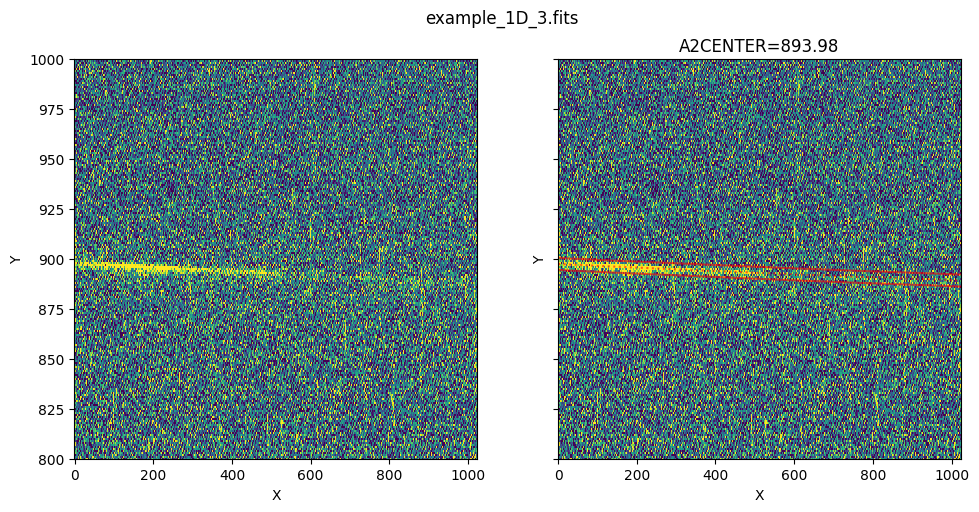

In [24]:
show_extraction_regions(x1d_filename, flt_filename, yrange=[800, 1000])

Zoom in to the background region above the extraction region:

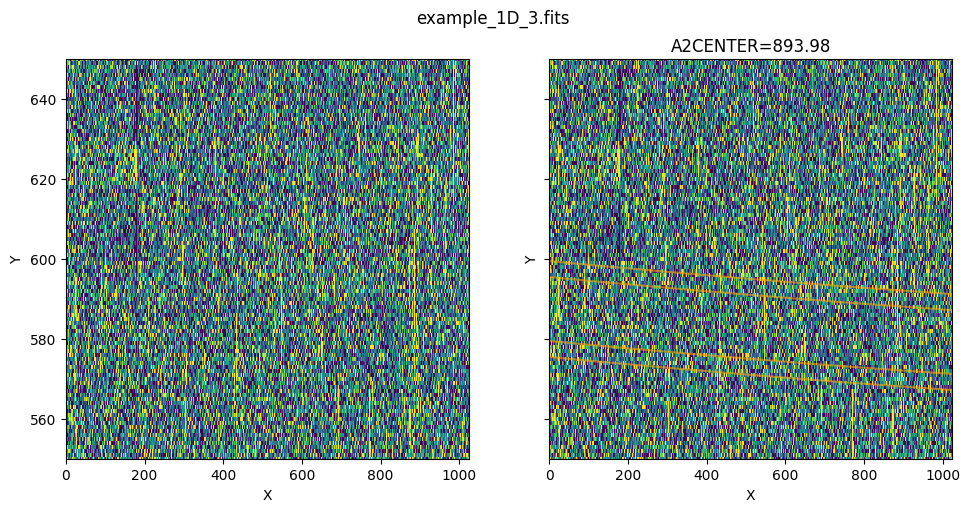

In [25]:
show_extraction_regions(x1d_filename, flt_filename, yrange=[550, 650])